In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import networkx as nx
import sklearn
import sklearn.metrics
import time

import gconcorde as cce

In [2]:
def get_precision(X):
    return .5*(np.diag(np.diag(X)) @ X) + .5*(X.T @ np.diag(np.diag(X)))

def mcc(B, B_hat, diag=False):
    """
    Compute Matthew's Correlation Coefficient (MCC) between two matrices.
    If diag=False, it excludes diagonal elements before computing MCC.
    """
    
    B_vec = B.ravel()
    B_hat_vec = B_hat.ravel()
    
    if diag:
        return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

    p = len(B)
    indx = np.arange(0, p**2, p+1)
    B_vec = np.where(B_vec != 0, 1, 0)
    B_vec = np.delete(B_vec, indx)
    B_hat_vec = np.where(B_hat_vec != 0, 1, 0)
    B_hat_vec = np.delete(B_hat_vec, indx)
    
    return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

def standardize(X, bias=False):
    X_std = X.copy()
    X_std -= X_std.mean(axis=0)
    if bias:
        X_std /= X_std.std(axis=0)
    else:
        X_std /= X_std.std(axis=0, ddof=1)
    
    return X_std

def omega_to_corr(A):
    std_inv = np.diag(np.sqrt(1/np.diag(A)))
    A_corr = -1 * (std_inv @ A @ std_inv)
    np.fill_diagonal(A_corr, 1)
    
    return A_corr

In [3]:
# erdos-renyi

# number of variables
p = 300
# number of datasets
N = 1
# n = n_prop_to_p * p
n_prop_to_p = [0.5]
edge_prob = 0.05
random_state = 2022
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]
G = nx.generators.random_graphs.erdos_renyi_graph(n=p, p=edge_prob, seed=random_state)
Skel = nx.to_numpy_matrix(G)

# Peng's method (ensuring positive definiteness of precision matrix)
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Omega = np.multiply(edge_weights, edge_signs)
Omega = np.multiply(Skel, Omega)
Omega = np.tril(Omega) + np.tril(Omega).T
np.fill_diagonal(Omega, 1.5*np.abs(Omega).sum(1))
diag_inv = np.diag(1/np.sqrt(np.diag(Omega)))
Omega = diag_inv @ Omega @ diag_inv

# spread diagonal of precision matrix
d = np.random.uniform(spread_diag[0], spread_diag[1], p)
Omega = np.diag(d) @ Omega @ np.diag(d)
Cov = np.linalg.inv(Omega)
Omega_corr = omega_to_corr(Omega)

# generate Gaussian data
Xs = []
for this in n_prop_to_p:
    for j in range(N):
        rs = np.random.RandomState(random_state)
        X = rs.multivariate_normal(mean=np.zeros(p), cov=Cov, size=int(this*p))
        X_std = standardize(X, bias=False)
        Xs.append(X_std)
        random_state += 1
        
# choose length of grid for lambda
num_lams = 10

In [4]:
# S = np.cov(Xs[0], rowvar=False)
# S.flat[::S.shape[0] + 1] = 0
# lam_max = 0.9 * np.max(np.abs(S))
# lam_min = 0.1 * lam_max
# lams = np.logspace(np.log10(lam_min), np.log10(lam_max), num_lams)
# S = np.cov(Xs[0], rowvar=False)

In [6]:
lam = 0.1

start_time = time.time()
Omega_hat_cce_diag, hist_cce_diag = cce.pycceista(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=True)
time_took_cce_diag = time.time() - start_time
Omega_hat_cce_diag = get_precision(Omega_hat_cce_diag)

start_time = time.time()   
Omega_hat_ccel_diag, hist_ccel_diag = cce.pycce_constant(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=True)
time_took_ccel_diag = time.time() - start_time
Omega_hat_ccel_diag = get_precision(Omega_hat_ccel_diag)

print(mcc(Omega, Omega_hat_cce_diag))
print(mcc(Omega, Omega_hat_ccel_diag))

start_time = time.time()
Omega_hat_cce, hist_cce = cce.pycceista(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=False)
time_took_cce = time.time() - start_time
Omega_hat_cce = get_precision(Omega_hat_cce)

start_time = time.time()   
Omega_hat_ccel, hist_ccel = cce.pycce_constant(S, lam, epstol=1e-5, maxitr=1000, penalize_diagonal=False)
time_took_ccel = time.time() - start_time
Omega_hat_ccel = get_precision(Omega_hat_ccel)

print(mcc(Omega, Omega_hat_cce))
print(mcc(Omega, Omega_hat_ccel))

/workspaces/gconcorde/gconcorde/gconcorde.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return Xn, np.array(run_info)
/workspaces/gconcorde/gconcorde/gconcorde.py:228: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return Xn, np.array(run_info)


0.031747642391633565
0.031747642391633565


/workspaces/gconcorde/gconcorde/gconcorde.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return Xn, np.array(run_info)


0.030938418255842946
0.030938418255842946


/workspaces/gconcorde/gconcorde/gconcorde.py:228: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return Xn, np.array(run_info)


In [7]:
# precision matrix
true_precision_matrix_cce_diag = get_precision(hist_cce_diag[-1][0])
Theta_minus_Theta_star_norm_cce_diag = [np.linalg.norm(np.eye(p) - true_precision_matrix_cce_diag)]
for i in range(len(hist_cce_diag)):
    Theta_minus_Theta_star_norm_cce_diag.append(np.linalg.norm(get_precision(hist_cce_diag[i][0])- true_precision_matrix_cce_diag))

true_precision_matrix_ccel_diag = get_precision(hist_ccel_diag[-1][0])
Theta_minus_Theta_star_norm_ccel_diag = [np.linalg.norm(np.eye(p) - true_precision_matrix_ccel_diag)]
for i in range(len(hist_ccel_diag)):
    Theta_minus_Theta_star_norm_ccel_diag.append(np.linalg.norm(get_precision(hist_ccel_diag[i][0]) - true_precision_matrix_ccel_diag))

true_precision_matrix_cce = get_precision(hist_cce[-1][0])
Theta_minus_Theta_star_norm_cce = [np.linalg.norm(np.eye(p) - true_precision_matrix_cce)]
for i in range(len(hist_cce)):
    Theta_minus_Theta_star_norm_cce.append(np.linalg.norm(get_precision(hist_cce[i][0])- true_precision_matrix_cce))

true_precision_matrix_ccel = get_precision(hist_ccel[-1][0])
Theta_minus_Theta_star_norm_ccel = [np.linalg.norm(np.eye(p) - true_precision_matrix_ccel)]
for i in range(len(hist_ccel)):
    Theta_minus_Theta_star_norm_ccel.append(np.linalg.norm(get_precision(hist_ccel[i][0]) - true_precision_matrix_ccel))

In [8]:
# Omega
Omega_minus_Omega_star_norm_cce_diag = [np.linalg.norm(np.eye(p) - hist_cce_diag[-1][0])]
for i in range(len(hist_cce_diag)):
    Omega_minus_Omega_star_norm_cce_diag.append(np.linalg.norm(hist_cce_diag[i][0] - hist_cce_diag[-1][0]))

Omega_minus_Omega_star_norm_ccel_diag = [np.linalg.norm(np.eye(p) - hist_ccel_diag[-1][0])]
for i in range(len(hist_ccel_diag)):
    Omega_minus_Omega_star_norm_ccel_diag.append(np.linalg.norm(hist_ccel_diag[i][0] - hist_ccel_diag[-1][0]))

Omega_minus_Omega_star_norm_cce = [np.linalg.norm(np.eye(p) - hist_cce[-1][0])]
for i in range(len(hist_cce)):
    Omega_minus_Omega_star_norm_cce.append(np.linalg.norm(hist_cce[i][0] - hist_cce[-1][0]))

Omega_minus_Omega_star_norm_ccel = [np.linalg.norm(np.eye(p) - hist_ccel[-1][0])]
for i in range(len(hist_ccel)):
    Omega_minus_Omega_star_norm_ccel.append(np.linalg.norm(hist_ccel[i][0] - hist_ccel[-1][0]))

In [9]:
time_took_per_iter_cce_diag = []
norm_diff_per_iter_cce_diag = []
obj_per_iter_cce_diag = []
for i in range(len(hist_cce_diag)):
    time_took_per_iter_cce_diag.append(hist_cce_diag[i][-1])
    norm_diff_per_iter_cce_diag.append(hist_cce_diag[i][2])
    obj_per_iter_cce_diag.append(hist_cce_diag[i][3])

time_took_per_iter_ccel_diag = []
norm_diff_per_iter_ccel_diag = []
obj_per_iter_ccel_diag = []
for i in range(len(hist_ccel_diag)):
    time_took_per_iter_ccel_diag.append(hist_ccel_diag[i][-1])
    norm_diff_per_iter_ccel_diag.append(hist_ccel_diag[i][2])
    obj_per_iter_ccel_diag.append(hist_ccel_diag[i][3])

time_took_per_iter_cce = []
norm_diff_per_iter_cce = []
obj_per_iter_cce = []
for i in range(len(hist_cce)):
    time_took_per_iter_cce.append(hist_cce[i][-1])
    norm_diff_per_iter_cce.append(hist_cce[i][2])
    obj_per_iter_cce.append(hist_cce[i][3])

time_took_per_iter_ccel = []
norm_diff_per_iter_ccel = []
obj_per_iter_ccel = []
for i in range(len(hist_ccel)):
    time_took_per_iter_ccel.append(hist_ccel[i][-1])
    norm_diff_per_iter_ccel.append(hist_ccel[i][2])
    obj_per_iter_ccel.append(hist_ccel[i][3])

In [10]:
time_took_cumsum_cce_diag = np.cumsum(time_took_per_iter_cce_diag)
time_took_cumsum_ccel_diag = np.cumsum(time_took_per_iter_ccel_diag)
time_took_cumsum_cce_diag = np.insert(time_took_cumsum_cce_diag, 0, 0)
time_took_cumsum_ccel_diag = np.insert(time_took_cumsum_ccel_diag, 0, 0)

time_took_cumsum_cce = np.cumsum(time_took_per_iter_cce)
time_took_cumsum_ccel = np.cumsum(time_took_per_iter_ccel)
time_took_cumsum_cce = np.insert(time_took_cumsum_cce, 0, 0)
time_took_cumsum_ccel = np.insert(time_took_cumsum_ccel, 0, 0)

In [11]:
mat = lam * np.ones((p, p), dtype="float64")
np.fill_diagonal(mat, 0)
h1 = -np.log(np.eye(p).diagonal()).sum() + 0.5*np.matmul(np.eye(p).T, np.matmul(np.eye(p), S)).trace()
h2 = (mat * np.abs(np.eye(p))).sum()
hn = h1 + h2
obj_per_iter_cce = np.insert(obj_per_iter_cce, 0, hn)
obj_per_iter_ccel = np.insert(obj_per_iter_ccel, 0, hn)


In [12]:
# objective values
f_star_cce = obj_per_iter_cce[-1]
f_star_ccel = obj_per_iter_ccel[-1]
f_minus_f_star_cce = obj_per_iter_cce - f_star_cce
f_minus_f_star_ccel = obj_per_iter_ccel - f_star_ccel

# ratio || x^{(t+1)} - x^* || / || x^{(t)} - x^* ||
ratio_cce = []
for i in range(len(f_minus_f_star_cce)-2):
    ratio_cce.append(np.abs(f_minus_f_star_cce[i+1])/np.abs(f_minus_f_star_cce[i]))

ratio_ccel = []
for i in range(len(f_minus_f_star_ccel)-2):
    ratio_ccel.append(np.abs(f_minus_f_star_ccel[i+1])/np.abs((f_minus_f_star_ccel[i])))

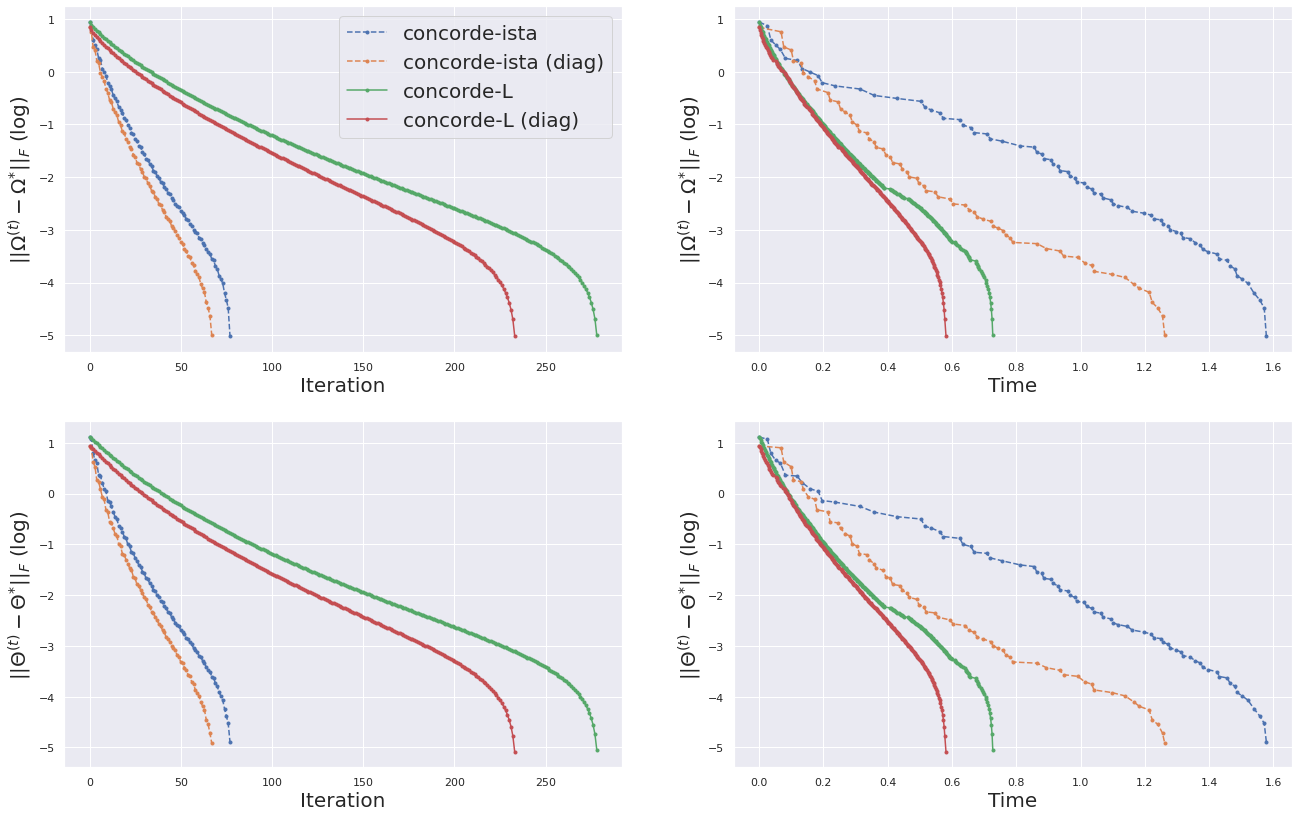

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(22, 14))
axes = axes.ravel()

for i in range(4):
    if i == 0:
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_cce)-1), np.log10(Omega_minus_Omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_cce_diag)-1), np.log10(Omega_minus_Omega_star_norm_cce_diag[:-1]), label='concorde-ista (diag)', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_ccel)-1), np.log10(Omega_minus_Omega_star_norm_ccel[:-1]), label='concorde-L', marker='.')
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_ccel_diag)-1), np.log10(Omega_minus_Omega_star_norm_ccel_diag[:-1]), label='concorde-L (diag)', marker='.')
        axes[i].legend(fontsize=20, loc='upper right')
        axes[i].set_xlabel('Iteration', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
    elif i == 1:
        axes[i].plot(time_took_cumsum_cce[:-1], np.log10(Omega_minus_Omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_cce_diag[:-1], np.log10(Omega_minus_Omega_star_norm_cce_diag[:-1]), label='concorde-ista (diag)', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_ccel[:-1], np.log10(Omega_minus_Omega_star_norm_ccel[:-1]), label='concorde-L', marker='.')
        axes[i].plot(time_took_cumsum_ccel_diag[:-1], np.log10(Omega_minus_Omega_star_norm_ccel_diag[:-1]), label='concorde-L (diag)', marker='.')
        axes[i].set_xlabel('Time', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
    elif i == 2:
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_cce)-1), np.log10(Theta_minus_Theta_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_cce_diag)-1), np.log10(Theta_minus_Theta_star_norm_cce_diag[:-1]), label='concorde-ista (diag)', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_ccel)-1), np.log10(Theta_minus_Theta_star_norm_ccel[:-1]), label='concorde-L', marker='.')
        axes[i].plot(np.arange(len(Omega_minus_Omega_star_norm_ccel_diag)-1), np.log10(Theta_minus_Theta_star_norm_ccel_diag[:-1]), label='concorde-L (diag)', marker='.')
        axes[i].set_xlabel('Iteration', fontsize=20)
        axes[i].set_ylabel('$|| \Theta^{(t)} - \Theta^{*} ||_F$ (log)', fontsize=20)
    elif i == 3:
        axes[i].plot(time_took_cumsum_cce[:-1], np.log10(Theta_minus_Theta_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_cce_diag[:-1], np.log10(Theta_minus_Theta_star_norm_cce_diag[:-1]), label='concorde-ista (diag)', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_ccel[:-1], np.log10(Theta_minus_Theta_star_norm_ccel[:-1]), label='concorde-L', marker='.')
        axes[i].plot(time_took_cumsum_ccel_diag[:-1], np.log10(Theta_minus_Theta_star_norm_ccel_diag[:-1]), label='concorde-L (diag)', marker='.')
        axes[i].set_xlabel('Time', fontsize=20)
        axes[i].set_ylabel('$|| \Theta^{(t)} - \Theta^{*} ||_F$ (log)', fontsize=20);
